In [20]:
import re
import random
import pandas as pd
import hashlib

In [21]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].mean() > 80: age_factor = .5
else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1/age_factor) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.05

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [22]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
Azure Private DNS,305.990474,16.104762,41.703768,19
RAG Project,489.993913,30.624620,101.449382,16
Azure AD Authentication,688.170370,52.936182,161.805590,13
Azure Functions + Visual Studio,740.837634,56.987510,271.680897,13
Email Auth and Security,818.351527,68.195961,169.752042,12
WSL + Kali Linux,1066.825367,76.201812,356.392177,14
Azure DevOps Pipelines,1096.650470,42.178864,89.226258,26
Asynchronous Python,1571.980826,34.173496,158.033261,46
Azure Functions + PP365,1610.182202,76.675343,252.633244,21
Open Source/GitHub,1688.141709,105.508857,351.638066,16


# Histogram

sum of ages: ~48769.45


<Axes: >

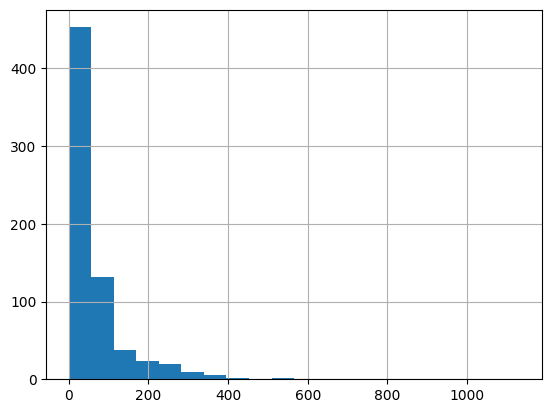

In [23]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

# Completely Random Shuffle

In [24]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [25]:
existing_cards = existing_cards.sort_values('age', ascending=False)
remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
existing_cards.head(10)

Cards found: 692
Total card age: 48769.45


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll
0,JavaScript Concepts,Service Workers: Scripts that run in the backg...,00ddfe24a50a0070e1e9326eaac0e608,1131.658916,90.494967,1131.658916,4796.233275,0.696315
1,Terraform,Variable Interpolation:\nThe process of embedd...,fcac2b6b90bd08ddb9a3ef905a9e0f4b,1006.890845,93.591024,1006.890845,2339.775594,0.466880
2,Audit Report Tracker (Sharepoint List),Item (SharePoint List Item)\nDefinition: A sin...,d0ce8d0da3df8f92b4ff3ca95fd426ca,937.256960,145.384335,937.256960,1744.612022,0.988560
3,Logging in Python,Q: How does RotatingFileHandler from the loggi...,60b9ac35727507199ed3d3b996ccab83,886.623971,165.409608,886.623971,4135.240204,0.942688
4,Logging in Python,Q: How can external log rotation tools like lo...,57b27fed5d075e5af65bbc29bdfdbaa4,644.387361,165.409608,886.623971,4135.240204,0.942688
5,Debugging in VS Code,Remote Debugging\nThe process of debugging cod...,ca5fab798a5c6204f74e192dcd55659b,613.045006,97.939812,613.045006,1860.856428,0.493801
6,Logging in Python,Q: What is the purpose of the disable_existing...,f803c674a61c80a7291f3ef06ceea119,539.653474,165.409608,886.623971,4135.240204,0.942688
7,Logging in Python,Q: What is one of the main disadvantages of us...,3753dbeb5ebfb4e424ec2fccd2df3557,534.401638,165.409608,886.623971,4135.240204,0.942688
8,Azure Developer Associate,Which Azure Monitor API lets you ingest custom...,ba1c9c8d01c752949032f768bd54b51c,500.592365,55.441373,500.592365,4878.840865,0.583002
9,Vocab,"Lost in a Good Book\nDoric columns: A simple, ...",7f5496b30d95587923948c9509df2835,433.755947,46.688354,433.755947,4155.263493,0.588346


# Headers with fewest notes first

In [26]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

# Focus on one header

In [27]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Header with oldest cards first

In [28]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest mean card age first

In [29]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest age sum first

In [30]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle


## Age Sum

In [31]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [32]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [33]:
# n = 4
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'age'], inplace=True)
## existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [34]:
# n=10
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'frequency', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [35]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [36]:
existing_cards.sort_values('age').head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll
668,Vocab,How to Sell a Haunted House\nTulle\nPronunciat...,7882c6b225695e0cebbeaf0c1736cf52,0.020550,46.688354,433.755947,4155.263493,0.588346
686,Vocab,How to Sell a Haunted House\nDebride a Wound\n...,27ff6eafcc1f92e11e68824a56125620,0.184825,46.688354,433.755947,4155.263493,0.588346
690,Asynchronous Python,Cooperative Multitasking\nThe async model in P...,71ac5b970658e9c888a90c4478508455,0.294109,34.173496,158.033261,1571.980826,0.381446
647,Vocab,How to Sell a Haunted House\nStollen (bread)\n...,00898156c7f97fe6353042f29ff89a8c,0.456120,46.688354,433.755947,4155.263493,0.588346
642,Vocab,How to Sell a Haunted House\nProbate\nPronunci...,5bf42f15b5ff93a0b11ad71e731f56f1,0.470302,46.688354,433.755947,4155.263493,0.588346
683,Azure Developer Associate,What’s the maximum retention you can configure...,d5ee457fbd0609a88312665b94d8621e,0.486172,55.441373,500.592365,4878.840865,0.583002
685,Python,Q:\nWhich Python module provides an object-ori...,e0f21808be1ac9152eaecf47c5a28d93,0.556714,90.501413,348.222098,4253.566417,0.544058
684,Vocab,How to Sell a Haunted House\nTruckle\nPronunci...,1444485fcf0c7f64e70be080a05ad6e2,0.582225,46.688354,433.755947,4155.263493,0.588346
689,JavaScript Concepts,Front: What are the benefits of using callback...,a2370fbf05a475780cf7c93745e623ab,0.653276,90.494967,1131.658916,4796.233275,0.696315
675,RAG Project,Blueprint\nA modular way to organize route han...,f860058819c5db5a8ee709fa4887e934,0.691008,30.624620,101.449382,489.993913,0.082479


In [37]:
existing_cards.head(10).sum()

head                   JavaScript ConceptsTerraformAudit Report Track...
body                   Service Workers: Scripts that run in the backg...
hash                   00ddfe24a50a0070e1e9326eaac0e608fcac2b6b90bd08...
age                                                          7228.266483
subject_mean_age                                             1191.178298
subject_highest_age                                          8169.695924
subject_age_sum                                             36316.542492
head_random_roll                                                7.587658
dtype: object

In [38]:
existing_cards['age'].mean()

70.47607851867193